In [39]:
import pandas as pd
from datetime import datetime
from lib_descriptive import plot_histograms
from lib_data import fetch_data, fetch_spot_prices
from lib_predictive import preprocess_data, split_data, normalize_data, reshape_data_LSTM, train_lstm_model, evaluate_model, predict_future, load_model

In [40]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator



In [41]:
pd.set_option('display.max_columns', None)

In [64]:
# asof = datetime.combine(datetime.now(), time.min)
asof = datetime(2024, 12, 1)
start_date = datetime(2020, 1, 1)
API_KEY = 'YOUR_DMI_API_KEY'
STATION_ID = '06030'  # Aalborg weather station
LAT, LON = 57.048, 9.9187 # Coordinates for Aalborg

In [65]:
historical_spot_prices = fetch_spot_prices(start_date, asof)
historical_wind_data = fetch_data("https://dmigw.govcloud.dk/v2/metObs/collections/observation/items", start_date, asof, 'wind_speed', STATION_ID, API_KEY, historical=True)
historical_temp_data = fetch_data("https://dmigw.govcloud.dk/v2/metObs/collections/observation/items", start_date, asof, 'temp_dry', STATION_ID, API_KEY, historical=True)

In [66]:
historical_temp_data

,observed,value
0,2020-01-01 00:00:00+00:00,3.766667
1,2020-01-01 01:00:00+00:00,4.983333
2,2020-01-01 02:00:00+00:00,5.216667
3,2020-01-01 03:00:00+00:00,5.116667
4,2020-01-01 04:00:00+00:00,5.283333
...,...,...
43100,2024-11-30 20:00:00+00:00,6.500000
43101,2024-11-30 21:00:00+00:00,6.616667
43102,2024-11-30 22:00:00+00:00,6.683333
43103,2024-11-30 23:00:00+00:00,6.466667


In [45]:
import lightgbm as lgb

In [67]:
df.head()

,HourDK,hour,epoch,weekday,day_of_year,hour_sin,hour_cos,weekday_sin,weekday_cos,PriceEUR,wind_speed,temperature
0,2020-01-01 00:00:00,0,1577836800000000000,2,1,0.000000,1.000000,0.974928,-0.222521,33.419998,5.850000,3.766667
1,2020-01-01 01:00:00,1,1577840400000000000,2,1,0.258819,0.965926,0.974928,-0.222521,31.770000,6.350000,4.983333
2,2020-01-01 02:00:00,2,1577844000000000000,2,1,0.500000,0.866025,0.974928,-0.222521,31.570000,6.533333,5.216667
3,2020-01-01 03:00:00,3,1577847600000000000,2,1,0.707107,0.707107,0.974928,-0.222521,31.280001,6.450000,5.116667
4,2020-01-01 04:00:00,4,1577851200000000000,2,1,0.866025,0.500000,0.974928,-0.222521,30.850000,6.450000,5.283333


In [47]:
import pandas as pd
import numpy as np

def prepare_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Prepares features for day-ahead price forecasting:
      - Creates day-ahead target PriceEUR_target (price shifted -24 hours).
      - Adds lagged price/weather features.
      - Adds rolling features.
      - Drops rows with NaN introduced by shifting/rolling.
    """
    df_prep = df.copy()

    # 1) Create day-ahead target
    # Shift price up by 24 hours so each row tries to predict next day's price.
    df_prep['PriceEUR_target'] = df_prep['PriceEUR'].shift(-24)

    # 2) Lagged features (common: 1 hour, 24 hours, 168 hours)
    for lag in [1, 24, 168]:
        df_prep[f'PriceEUR_lag{lag}']    = df_prep['PriceEUR'].shift(lag)
        df_prep[f'wind_speed_lag{lag}']  = df_prep['wind_speed'].shift(lag)
        df_prep[f'temp_lag{lag}']        = df_prep['temperature'].shift(lag)

    # 3) Rolling features (e.g., 24h / 168h rolling means)
    for window in [24, 168]:
        df_prep[f'PriceEUR_roll{window}'] = (
            df_prep['PriceEUR'].shift(1)
            .rolling(window=window, min_periods=1)
            .mean()
        )
        df_prep[f'wind_speed_roll{window}'] = (
            df_prep['wind_speed'].shift(1)
            .rolling(window=window, min_periods=1)
            .mean()
        )
        df_prep[f'temp_roll{window}'] = (
            df_prep['temperature'].shift(1)
            .rolling(window=window, min_periods=1)
            .mean()
        )

    # 4) Drop rows with NaN
    df_prep.dropna(inplace=True)

    return df_prep


In [48]:
df = preprocess_data(historical_spot_prices, historical_wind_data, historical_temp_data)

In [49]:
# prepare_features(df)
df_prepared = prepare_features(df)

In [50]:
df_prepared.head()

,HourDK,hour,epoch,weekday,day_of_year,hour_sin,hour_cos,weekday_sin,weekday_cos,PriceEUR,wind_speed,temperature,PriceEUR_target,PriceEUR_lag1,wind_speed_lag1,temp_lag1,PriceEUR_lag24,wind_speed_lag24,temp_lag24,PriceEUR_lag168,wind_speed_lag168,temp_lag168,PriceEUR_roll24,wind_speed_roll24,temp_roll24,PriceEUR_roll168,wind_speed_roll168,temp_roll168
168,2020-01-08 00:00:00,0,1578441600000000000,2,8,0.000000,1.000000,0.974928,-0.222521,18.950001,12.650000,7.900000,25.209999,24.209999,13.566667,7.850000,28.280001,6.950000,5.016667,33.419998,5.850000,3.766667,33.497917,7.003472,6.171528,28.522917,7.283631,5.347718
169,2020-01-08 01:00:00,1,1578445200000000000,2,8,0.258819,0.965926,0.974928,-0.222521,4.960000,11.466667,7.833333,25.340000,18.950001,12.650000,7.900000,28.340000,6.783333,4.816667,31.770000,6.350000,4.983333,33.109167,7.240972,6.291667,28.436786,7.324107,5.372321
170,2020-01-08 02:00:00,2,1578448800000000000,2,8,0.500000,0.866025,0.974928,-0.222521,0.100000,12.183333,8.516667,27.740000,4.960000,11.466667,7.833333,28.469999,6.950000,4.866667,31.570000,6.533333,5.216667,32.135000,7.436111,6.417361,28.277202,7.354563,5.389286
171,2020-01-08 03:00:00,3,1578452400000000000,2,8,0.707107,0.707107,0.974928,-0.222521,0.110000,12.250000,8.983333,32.110001,0.100000,12.183333,8.516667,28.110001,6.016667,4.950000,31.280001,6.450000,5.116667,30.952917,7.654167,6.569444,28.089881,7.388194,5.408929
172,2020-01-08 04:00:00,4,1578456000000000000,2,8,0.866025,0.500000,0.974928,-0.222521,1.750000,12.950000,8.800000,29.000000,0.110000,12.250000,8.983333,28.700001,4.866667,5.200000,30.850000,6.450000,5.283333,29.786250,7.913889,6.737500,27.904345,7.422718,5.431944


In [51]:
target_col = 'PriceEUR'

In [52]:
drop_cols = ['HourDK', 'PriceEUR']  # We'll treat PriceEUR as target
feature_cols = [col for col in df_prepared.columns if col not in drop_cols]

In [53]:
X = df_prepared[feature_cols]
y = df_prepared[target_col]

In [54]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=False, test_size=0.2
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (34040, 26) Test shape: (8511, 26)


In [61]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def train_lightgbm_day_ahead(df_prepared: pd.DataFrame, split_date: str):
    """
    Trains a LightGBM model for day-ahead price forecasting.
    :param df_prepared: DataFrame from prepare_features()
    :param split_date:  Date string (e.g., '2022-01-01') for time-based train/test split
    :return: fitted model, X_test, y_test
    """

    # 1) Split into training (before split_date) and testing (after split_date)
    train_data = df_prepared[df_prepared['HourDK'] < split_date]
    test_data  = df_prepared[df_prepared['HourDK'] >= split_date]

    # 2) Define features and target
    features_to_drop = [
        'HourDK',           # not used as numeric feature
        'PriceEUR',         # the *current* known price
        'PriceEUR_target'   # we’ll define it as y
    ]
    feature_cols = [c for c in df_prepared.columns if c not in features_to_drop]

    X_train = train_data[feature_cols]
    y_train = train_data['PriceEUR_target']

    X_test = test_data[feature_cols]
    y_test = test_data['PriceEUR_target']

    # 3) Create LightGBM Datasets
    dtrain = lgb.Dataset(X_train, label=y_train)
    dtest  = lgb.Dataset(X_test, label=y_test)

    # 4) Define model parameters (example starter values)
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'seed': 42
    }

    # 5) Train LightGBM with early stopping on the test set
    model = lgb.train(
        params,
        dtrain,
        num_boost_round=2000,
        valid_sets=[dtrain, dtest],
        valid_names=['train','test']
    )

    # 6) Evaluate on test set
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"Day-ahead forecasting: Test MAE = {mae:.2f}, Test RMSE = {rmse:.2f}")

    return model, X_test, y_test

In [62]:
split_date = '2022-01-01'  # train up to end of 2021, test on 2022+
model, X_test, y_test = train_lightgbm_day_ahead(df_prepared, split_date)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4922
[LightGBM] [Info] Number of data points in the train set: 17109, number of used features: 25
[LightGBM] [Info] Start training from score 56.328036
Day-ahead forecasting: Test MAE = 58.16, Test RMSE = 70.03


In [63]:
def forecast_future_days(model, df_latest, forecast_horizon_days=7):
    """
    Iteratively forecasts day-ahead prices for a given horizon (e.g. 7 or 30 days).
    :param model: a LightGBM model trained to predict day-ahead prices
    :param df_latest: the most recent slice of your data, must contain the
                      necessary lag/rolling columns up to the last known real hour
    :param forecast_horizon_days: how many days to forecast
    :return: a DataFrame with the forecasted prices for each future day
    """

    # We'll create a working copy of df_latest to append new rows as we forecast.
    # Make sure df_latest has at least 168 hours of history for weekly lags, etc.
    df_future = df_latest.copy()

    # Start from the last available timestamp
    current_time = df_future['HourDK'].max()

    forecasts = []

    for day_ahead in range(1, forecast_horizon_days + 1):
        # The "target" day we are predicting (day ahead of the last known data):
        forecast_time = current_time + pd.Timedelta(days=1)

        # Build a single new row of features for 'forecast_time'
        # That means: shift the existing columns (PriceEUR_lag1, etc.)
        # We'll do so by referencing the last row in df_future.
        new_row = build_feature_row_for_forecast(df_future, forecast_time)

        # Predict the price with the model
        pred_price = model.predict(new_row)[0]

        # Save the forecast result
        forecasts.append({
            'HourDK': forecast_time,
            'forecast_price': pred_price
        })

        # Append this "predicted" data back into df_future so subsequent lags
        # can reference it. For day-ahead, we treat the predicted price as if it's the
        # "current" price for the next iteration.
        df_future = append_predicted_row(df_future, new_row, pred_price, forecast_time)

        # Update current_time
        current_time = forecast_time

    return pd.DataFrame(forecasts)

(29920, 10) (6411, 10) (6412, 10)
(29920, 1) (6411, 1) (6412, 1)


In [73]:
import pandas as pd
import numpy as np

def prepare_features_hourly(df: pd.DataFrame) -> pd.DataFrame:
    """
    Prepares features for *hour-ahead* price forecasting.
      - Creates next-hour target: PriceEUR_target = PriceEUR.shift(-1)
      - Adds lagged price, wind_speed, temperature, etc.
      - Adds rolling means (e.g., last 24h, 168h).
      - Drops rows with NaN introduced by shifting/rolling.

    Assumes the DataFrame has:
      - 'HourDK' (datetime)
      - 'PriceEUR'
      - 'wind_speed'
      - 'temperature'
      - possibly cyclical/time columns (e.g. hour_sin, weekday_sin, etc.).

    Returns: a new DataFrame with these extra columns + target.
    """
    df_prep = df.copy()

    # 1) Next-hour price as the target
    df_prep['PriceEUR_target'] = df_prep['PriceEUR'].shift(-1)

    # 2) Create lagged features (common lags: 1 hour, 24 hours, 168 hours)
    for lag in [1, 24, 168]:
        df_prep[f'PriceEUR_lag{lag}']    = df_prep['PriceEUR'].shift(lag)
        df_prep[f'wind_speed_lag{lag}']  = df_prep['wind_speed'].shift(lag)
        df_prep[f'temp_lag{lag}']        = df_prep['temperature'].shift(lag)

    # 3) Rolling means/stats
    for window in [24, 168]:
        df_prep[f'PriceEUR_roll{window}'] = (
            df_prep['PriceEUR']
            .shift(1)                        # shift by 1 to avoid leakage
            .rolling(window=window, min_periods=1)
            .mean()
        )
        df_prep[f'wind_speed_roll{window}'] = (
            df_prep['wind_speed']
            .shift(1)
            .rolling(window=window, min_periods=1)
            .mean()
        )
        df_prep[f'temp_roll{window}'] = (
            df_prep['temperature']
            .shift(1)
            .rolling(window=window, min_periods=1)
            .mean()
        )

    # 4) Drop rows with NaN from shifting/rolling
    df_prep.dropna(inplace=True)

    return df_prep

In [79]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

def train_lightgbm_hourly(df_prepared: pd.DataFrame, split_date: str):
    """
    Trains a LightGBM model for *hour-ahead* price forecasting.
    :param df_prepared: DataFrame from prepare_features_hourly()
    :param split_date:  Date string (e.g., '2023-01-01') for time-based split
    :return: (model, X_test, y_test)
    """

    # 1) Split the data
    train_data = df_prepared[df_prepared['HourDK'] < split_date]
    test_data  = df_prepared[df_prepared['HourDK'] >= split_date]

    # 2) Define features and target
    # We'll drop columns that are not used as inputs:
    features_to_drop = ['HourDK', 'PriceEUR', 'PriceEUR_target']
    feature_cols = [c for c in df_prepared.columns if c not in features_to_drop]

    X_train = train_data[feature_cols]
    y_train = train_data['PriceEUR_target']
    X_test  = test_data[feature_cols]
    y_test  = test_data['PriceEUR_target']

    # 3) Create LightGBM datasets
    dtrain = lgb.Dataset(X_train, label=y_train)
    dtest  = lgb.Dataset(X_test, label=y_test)

    # 4) Set LightGBM params
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'seed': 42
    }

    # 5) Train the model, using early stopping on the test set
    model = lgb.train(
        params,
        dtrain,
        num_boost_round=2000,
        valid_sets=[dtrain, dtest],
        valid_names=['train','test']
    )

    # 6) Evaluate
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    mae  = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)
    print(f"Hour-ahead forecasting on test set after {split_date}:")
    print(f"  MAE  = {mae:.2f}")
    print(f"  RMSE = {rmse:.2f}")

    return model, X_test, y_test


In [75]:
import pandas as pd

def show_prediction_vs_actual(
    model, 
    X_test, 
    y_test, 
    n=20, 
    plot=True, 
    hours_to_plot=None
):
    """
    Generates predictions using the provided model and shows
    predicted vs. actual prices for each hour in the test set.

    Parameters
    ----------
    model : fitted regression model (e.g. LightGBM)
    X_test : pandas DataFrame
        Features for the test subset. Should share index with y_test.
        Ideally has a DateTimeIndex or at least some index that matches y_test.
    y_test : pandas Series or array
        Actual next-hour prices, aligned with X_test's index.
    n : int, optional
        Number of rows to display in the printed comparison.
    plot : bool, optional
        If True, produce a simple plot of predicted vs. actual.
    hours_to_plot : int or None, optional
        If an integer is provided, we show only the last 'hours_to_plot' hours in the plot.
        If None, we plot the entire test set.
    """

    # 1) Predict
    y_pred = model.predict(X_test)

    # 2) Create a comparison DataFrame
    df_compare = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred
    }, index=y_test.index)

    # 3) Print sample of first n rows
    print(f"\nSample of Actual vs. Predicted (first {n} rows):")
    print(df_compare.head(n))

    # 4) Plot
    if plot:
        df_compare_plot = df_compare.copy()

        if hours_to_plot is not None:
            # If we have a DateTimeIndex, let's slice the last N hours
            # by index position or by time. If your index is truly a DateTimeIndex,
            # you can do time-based slicing. If it's numeric, do .iloc[-hours_to_plot:].
            df_compare_plot = df_compare_plot.iloc[-hours_to_plot:]
        
        # Plot
        df_compare_plot.plot(figsize=(10, 4), marker='o')
        plt.title('Hour-Ahead: Actual vs. Predicted')
        plt.xlabel('Time Index (Hourly)')
        plt.ylabel('Price')
        plt.legend()
        plt.tight_layout()
        plt.show()


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4924
[LightGBM] [Info] Number of data points in the train set: 25814, number of used features: 25
[LightGBM] [Info] Start training from score 100.453713
Hour-ahead forecasting on test set after 2023-01-01:
  MAE  = 14.53
  RMSE = 430.15

Sample of Actual vs. Predicted (first 10 rows):
       Actual  Predicted
26304    1.38   2.120171
26305    0.09   3.413738
26306    0.08   3.672986
26307    0.05   5.404593
26308    0.00   9.076030
26309   -0.38   7.820311
26310    0.00   9.038913
26311    0.00  14.558556
26312    0.04  16.974794
26313    0.80  20.555810


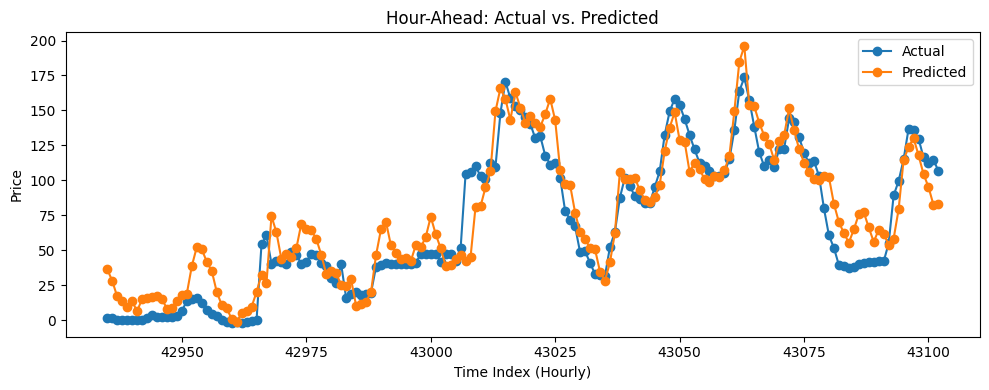

In [80]:

#    If you want HourDK as an index for convenience:
#    df_raw.set_index('HourDK', inplace=True)
# 2) Prepare features for HOUR-AHEAD
df_prep = prepare_features_hourly(df)
# 3) Choose a split date for train/test
split_date = '2023-01-01'
model, X_test, y_test = train_lightgbm_hourly(df_prep, split_date)
# 4) Show results for every hour in the test set
show_prediction_vs_actual(
    model, X_test, y_test,
    n=10,
    plot=True,
    hours_to_plot=168  # last 168 hours (1 week) in the plot
)

In [31]:
# Reshape data for LSTM
X_train, X_val, X_test = reshape_data_LSTM(X_train, X_val, X_test)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

# generator_training = TimeseriesGenerator(X_train, y_train, length=24, batch_size=32)
# generator_test = TimeseriesGenerator(X_test, y_test, length=24, batch_size=32)
# generator_validation = TimeseriesGenerator(X_val, y_val, length=24, batch_size=32)

(29920, 1, 10) (6411, 1, 10) (6412, 1, 10)
(29920, 1) (6411, 1) (6412, 1)


In [32]:
# Train LSTM model
model, history = train_lstm_model(X_train, y_train, X_val, y_val)

Epoch 1/20
234/234 - 13s - 56ms/step - loss: 0.0199 - val_loss: 0.0059
Epoch 2/20
234/234 - 2s - 7ms/step - loss: 0.0116 - val_loss: 0.0057
Epoch 3/20
234/234 - 2s - 9ms/step - loss: 0.0110 - val_loss: 0.0055
Epoch 4/20
234/234 - 2s - 7ms/step - loss: 0.0110 - val_loss: 0.0055
Epoch 5/20
234/234 - 2s - 7ms/step - loss: 0.0112 - val_loss: 0.0057
Epoch 6/20
234/234 - 2s - 7ms/step - loss: 0.0113 - val_loss: 0.0059
Epoch 7/20
234/234 - 2s - 7ms/step - loss: 0.0121 - val_loss: 0.0064
Epoch 8/20
234/234 - 2s - 7ms/step - loss: 0.0125 - val_loss: 0.0070
Epoch 9/20
234/234 - 2s - 7ms/step - loss: 0.0131 - val_loss: 0.0076
Epoch 10/20
234/234 - 2s - 8ms/step - loss: 0.0135 - val_loss: 0.0083
Epoch 11/20
234/234 - 2s - 8ms/step - loss: 0.0137 - val_loss: 0.0088
Epoch 12/20
234/234 - 2s - 7ms/step - loss: 0.0135 - val_loss: 0.0097
Epoch 13/20
234/234 - 2s - 7ms/step - loss: 0.0141 - val_loss: 0.0103
Epoch 14/20
234/234 - 2s - 7ms/step - loss: 0.0139 - val_loss: 0.0110
Epoch 15/20
234/234 - 2s - 

201/201 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Mean Absolute Error: 0.16 EUR


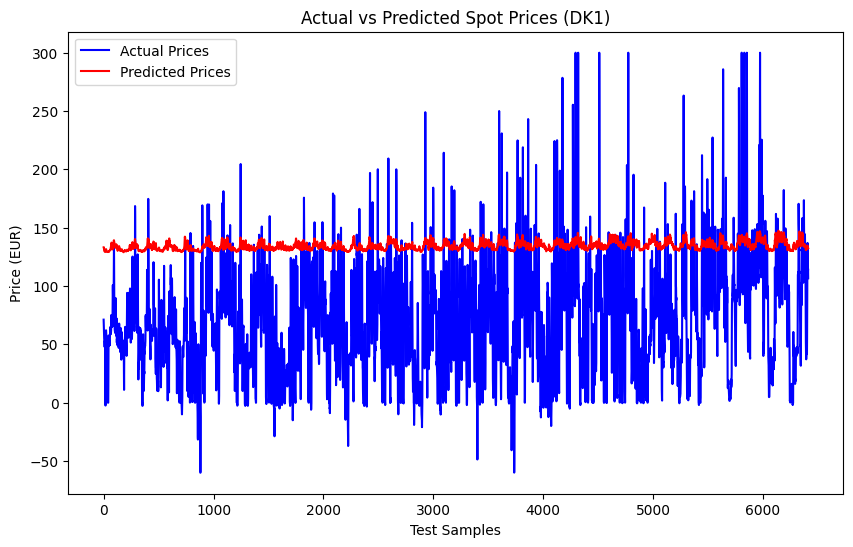

In [33]:
from lib_descriptive import plot_predictions


predictions = evaluate_model(model, X_test, y_test)
scaled_predictions = scaler_y.inverse_transform(predictions)
scaled_y_test = scaler_y.inverse_transform(y_test)
plot_predictions(scaled_y_test, scaled_predictions)

In [34]:
# Load the model for future predictions
import lib_predictive
import lib_descriptive
import lib_prescriptive
from keras.models import load_model

model = load_model('lstm_model.keras')

201/201 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


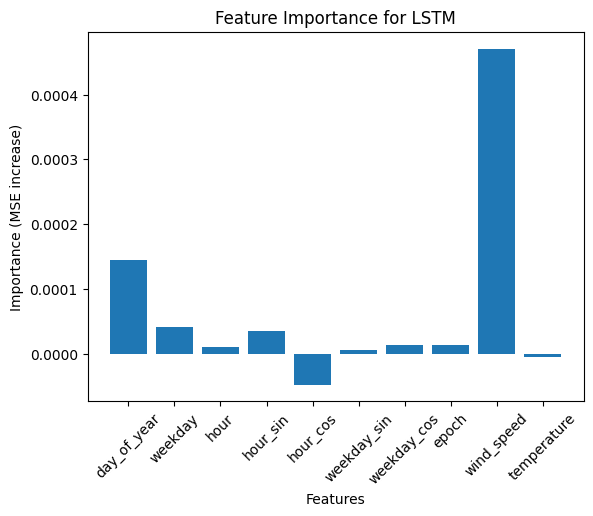

In [35]:
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
baseline_mse = mean_squared_error(y_test, model.predict(X_test))

def permutation_importance(model, X_test, y_test, baseline_mse):
    importances = []
    for feature in range(X_test.shape[2]):
        X_permuted = X_test.copy()
        np.random.shuffle(X_permuted[:, :, feature])  # Shuffle one feature at a time
        mse = mean_squared_error(y_test, model.predict(X_permuted))
        importances.append(mse - baseline_mse)
    return importances

# Compute feature importances
importances = permutation_importance(model, X_test, y_test, baseline_mse)

# Assuming feature names are available
feature_names = features
plt.bar(feature_names, importances)
plt.xlabel('Features')
plt.ylabel('Importance (MSE increase)')
plt.title('Feature Importance for LSTM')
plt.xticks(rotation=45)
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step


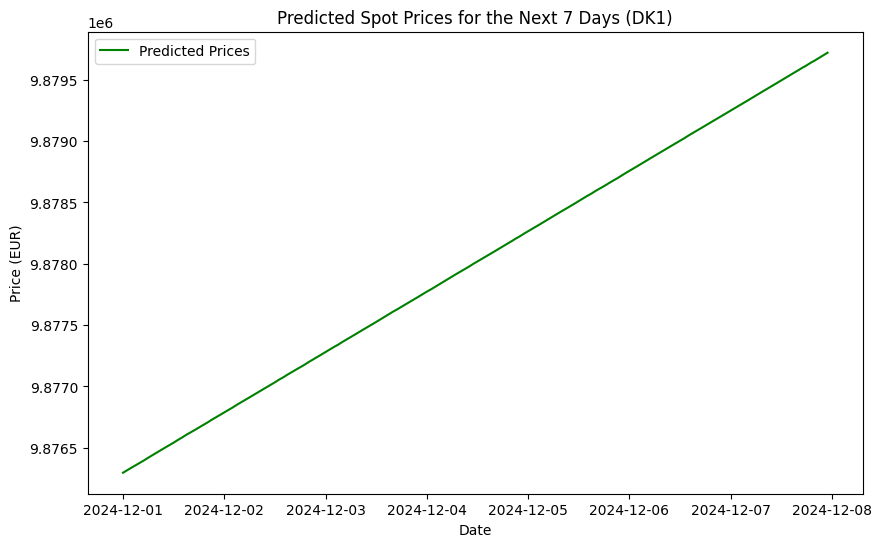

In [36]:

future_df = predict_future(model, asof)
# rescale priceEUR to original scale
future_df['PriceEUR'] = scaler_y.inverse_transform(future_df['PriceEUR'].values.reshape(-1, 1))


In [37]:
print(future_df)
print(predictions)

         PriceEUR              HourDK
0    4.246413e+09 2024-12-01 00:00:00
1    4.246422e+09 2024-12-01 01:00:00
2    4.246430e+09 2024-12-01 02:00:00
3    4.246439e+09 2024-12-01 03:00:00
4    4.246448e+09 2024-12-01 04:00:00
..            ...                 ...
163  4.247850e+09 2024-12-07 19:00:00
164  4.247858e+09 2024-12-07 20:00:00
165  4.247867e+09 2024-12-07 21:00:00
166  4.247876e+09 2024-12-07 22:00:00
167  4.247885e+09 2024-12-07 23:00:00

[168 rows x 2 columns]
[[0.6119788 ]
 [0.61102676]
 [0.6105051 ]
 ...
 [0.6097752 ]
 [0.61090684]
 [0.61031103]]


In [38]:
future_df

,PriceEUR,HourDK
0,4.246413e+09,2024-12-01 00:00:00
1,4.246422e+09,2024-12-01 01:00:00
2,4.246430e+09,2024-12-01 02:00:00
3,4.246439e+09,2024-12-01 03:00:00
4,4.246448e+09,2024-12-01 04:00:00
...,...,...
163,4.247850e+09,2024-12-07 19:00:00
164,4.247858e+09,2024-12-07 20:00:00
165,4.247867e+09,2024-12-07 21:00:00
166,4.247876e+09,2024-12-07 22:00:00
